# YOLOv3 Tutorial

This is a complete tutorial for understanding and implementing YoloV3 with keras/tensorflow. Yolo stands for "You only look once" and is an algorithm, which enables us to detect, locate and classify objects on images. The creator of Yolo is Joseph Redmon (pjreddie) and you can find his papers for YoloV1, YoloV2 and YoloV3 on the internet. For this tutorial no knowledge of the first two versions are needed. All you need is basic knowledge of python. So let me show you what Yolo is capable of: [YOLOv3 demonstration](https://www.youtube.com/watch?v=MPU2HistivI)

### The YOLOv3 algorithm

YOLOv3 creates bounding boxes around objects with a class assigned to them. Before we implement a model and train it to do this task we need lots of data.
What we need for YOLOv3 is a dataset with images and labels, which annotate the location, class and size of objects inside the images. Ideally we have the following properties for our dataset:
- many images
- less noisy images
- accurate annotations
- relativ shape of images are roughly quadratic and/or similar to eachother

Typically images are in the format of jpeg or png and the format of the annotations look like this:
[label_id, x1, y1, x2, y2] or [label_id, x, y, w, h]

The label_id defines the object class (label encoding), (x1,y1) define the upper left corner bounding box and (x2,y2) the lower right corner.

Each image can have multiple objects and each object is assigned one class (or more like in the original paper). 

### loading the dataset

In the first step we want to load our dataset.

### intersection over union

For object detection algorithms it is important to know what intersection over union (IoU) is, because it is extensively used in YOLOv3 and other algorithms. The intersection over union gives us as 'measurement' how well to 2 boxes overlap. The intersection over union is defined as the intersection of two boxes divided by the union. Two identical boxes will give a IoU of 1 and boxes which dont overlap at all will give an IoU of 0. For all other cases the IoU will give values between 0 and 1.

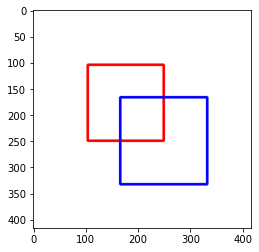

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

img = np.ones((416,416,3))
boxA = np.array([0.25,0.25,0.6,0.6]) 
boxB = np.array([0.4,0.4,0.8,0.8])

x1,y1,x2,y2 = np.array(boxA * 416, dtype=np.int16)
img = cv2.rectangle(img, (x1, y1), (x2, y2), color=(1,0,0), thickness=3)

x1,y1,x2,y2 = np.array(boxB * 416, dtype=np.int16)
img = cv2.rectangle(img, (x1, y1), (x2, y2), color=(0,0,1), thickness=3)

plt.imshow(img)

In [105]:
def intersectionOverUnion(boxA,boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
    x1 = np.maximum(boxA[0], boxB[0])
    y1 = np.maximum(boxA[1], boxB[1])
    x2 = np.minimum(boxA[2], boxB[2])
    y2 = np.minimum(boxA[3], boxB[3])

    #compute the area of intersection rectangle
    interArea = np.maximum(0., x2 - x1)*np.maximum(0., y2 - y1)
    
    #compute the area of both the prediction and ground-truth
    #rectangles
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    # Compute the intersection over union by taking the intersection
    # Area and dividing it by the sum of prediction + ground-truth
    # Areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
 
    return iou

print(intersectionOverUnion(boxA,boxB))

0.1649484536082473


Now we check if the IoU makes sense.
From the plot we can see, that the boxes A and B are designed so, that 1 quarter section of each box overlaps. Since area of the union is made up of 7 such quarter sections our resultion IoU is simply 1/7, which is the result of our computed answer.

### Non Maximum Suppression (NMS)

This is a very important post processing step for output of the YOLOv3 model. It is designed so that it proposes mulitple bounding boxes for a detected object. We filter those, which leaves us with proposals with high confidence and no redundant predictions for the same object. This is done by the following steps:
- Omit all predictions with a confidence higher than a certain threshold
- Use intersection over union and the predicted class to omit redundant predictions of the same object

So lets take a look at an example. First generate a bunch of boxes which we assume are the predictions of our model.

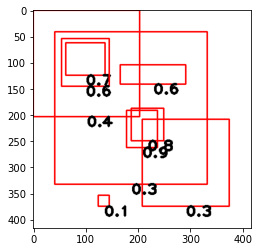

In [106]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

bboxes = [
    [1. ,0.9,0.43, 0.46, 0.57, 0.63],
    [1. ,0.8,0.45, 0.45, 0.6, 0.6],
    [1. ,0.7,0.15, 0.15, 0.33, 0.3],
    [1. ,0.6,0.13, 0.13, 0.35, 0.35],
    [1. ,0.6,0.4, 0.25, 0.7, 0.34],
    [1. ,0.4,0. , 0. , 0.49 , 0.49 ],
    [1. ,0.3,0.5 , 0.5 , .90, .90],
    [1. ,0.3,0.1 , 0.1 , .8, .8],
    [1. ,0.1,0.3, 0.85, 0.35, 0.9],
]

img = np.ones((416,416,3))
for box in bboxes:
    x1,y1,x2,y2 = np.array(np.array(box[2:]) * 416, dtype=np.int16)
    img = cv2.rectangle(img, (x1,y1), (x2,y2), color=(1,0,0), thickness=2)
    img = cv2.putText(img, str(box[1]), (x2-int((x2-x1)/2),y2+20), fontFace=1, fontScale= 2, color=(0,0,0), thickness=3 )
plt.imshow(img)

Now we implement the non maximum suppression algorithm without looking at classes. It takes all candidate boxes and keep only predictions above a treshold (here: 0.5). Then we sort the boxes by the confidence and apply our intersection over union function. We start with prediction with the highest confidence and calculcate the IoU to all predictions after it. If the IoU is above a certain threshold (here: 0.5) then we assume that these are predictions for the same object and we omit the prediction with the lower confidence. We repeat this with 2nd highest confidence and so on... until only a couple of unique predictions above a certain confidence are left.

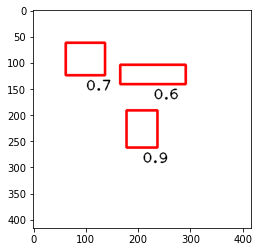

In [107]:
def nonMaximumSupression(bboxes, thresh_iou, thresh_conf):
    # bboxes = [grid*grid, (class, conf, x, y, w, h)]
    
    assert type(bboxes) == list
    
    bboxes = [box for box in bboxes if box[1] > thresh_conf]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    # bboxes_after_nms = []
    
    i=0
    while i <= len(bboxes):
        j = i +1
        while j < len(bboxes):
            iou = intersectionOverUnion(bboxes[i][2:], bboxes[j][2:])
            if iou > thresh_iou:
                del bboxes[j]
            else:
                j +=1
        i += 1
    
    return bboxes

nms_boxes = nonMaximumSupression(bboxes, 0.5, 0.5)
img = np.ones((416,416,3))
for box in nms_boxes:
    x1,y1,x2,y2 = np.array(np.array(box[2:]) * 416, dtype=np.int16)
    img = cv2.rectangle(img, (x1,y1), (x2,y2), color=(1,0,0), thickness=3)
    img = cv2.putText(img, str(box[1]), (x2-int((x2-x1)/2),y2+30), fontFace=1, fontScale= 2, color=(0,0,0), thickness=2 )
plt.imshow(img)

We can see that predictions under a the confidence threshold were omitted. The big box prediction with 0.3 confidence vanished. If you look at the top left prediction with 0.7 confidence, you can see that it had an IoU above 0.5 with the other overlapping bounding box with a confidence of 0.6. Since 0.7 is higher, we kept that box.

## Target shape

If we input an image into our YOLOv3 model, we get an output. Now we compare the output with the true annotation of the same image and calculate a loss, which measures how good our prediction is. With backpropagation our model parameters are adjusted to and if we repeat these steps with multiple images and multiple times, we get our training algorithm. But in order get there we need our labels to be in a specific shape, which matches the output of our model.

We divide our image in grids

## Neural Net

No we implement the neural network. The neural network can be separated in two parts: The feature extractor and the detection heads. The feature extractor used in YOLOv3 is also called darknet53, because is uses 53 convolutional layers. Our convoloutional layer have eather kernel size 1 by 1 or 3 by 3. After each convolutional layer follows are batch normalization layer and a leakyReLu as activation function. We will group this 3 in a convolutional block. Sometimes the convolutional layer uses a stride of 2. If that is the case, we will use zero padding immediately after the convolutional layer. Then batch normalization and leakyReLu follow.

In [1]:
import keras
from keras.layers import (
    BatchNormalization, Conv2D, UpSampling2D, Concatenate, ZeroPadding2D, Lambda
    )

def conv_block(x, filter_number, kernel_size, stride=1, batch_norm=True):
    # padding = 'same'
    if stride == 1:
        padding = 'same'
    else:
        x = ZeroPadding2D(((1, 0), (1, 0)))(x)  # top left half-padding
        padding = 'valid'
    x = Conv2D(filters=filter_number, 
               kernel_size=(kernel_size,kernel_size), 
               strides=(stride,stride), 
               padding = padding, 
               use_bias=not batch_norm)(x)
    if batch_norm is True:
        x = BatchNormalization()(x)
        x = LeakyReLU(alpha=0.1)(x)
    return x

Another block we will implement is the residual block. This blocks has two convolutional blocks with kernel size 1 by 1 and 3 by 3. In additiion we have residual skip: We concatenate the input before the first convolutional block with the output of the second convolutional block. This skip results in better training behaviour.

In [2]:
# Format for the arguments of res_block (example)
# x: input, filter_list: [32,64], repeats: 2

def res_block(x, filter_list, repeats):
    for i in range(repeats):
        res_skip = x
        x = conv_block(x, filter_list[0], 1)
        x = conv_block(x, filter_list[1], 3)
        x = add([res_skip, x])
    return x


For convenience we implement an additional block, which consists only of convolutional layers. This block is used in the detection head:

In [3]:
# Format for the arguments of filters_numbers, kernel_sizes, strides
# [32,64,...], [1,3,...], [1,2,...] <- all same length
def conv_block_2(x, filter_numbers, kernel_sizes, strides):
    for i, filter_number in enumerate(filter_numbers):
        kernel_size = kernel_sizes[i]
        stride = strides[i]
        x = conv_block(x, filter_number, kernel_size, stride)
    return x

## Using pre-training with COCO-weights

The original YOLOv3 model used pre-training of the darknet on imagenet. ImageNet is a database for image classification task. The weight from that pre-trained darknet53 are then loaded in the darknet53 of the YOLO model. We could do this too, by implementing the darknet53 with a dense layer and training it with a dataset with classification annotations (e.g. ImageNet). Or we can just download the pre-trained weights from and load them directly into our darknet53 implementation. 